# Importing Libraries

In [1]:
pip install hyperopt lazypredict -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from hyperopt import hp, fmin, tpe, STATUS_OK
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/mendeley-heart-attack-dataset/Medicaldataset.csv


# Importing Dataset

In [3]:
df = pd.read_csv('/kaggle/input/mendeley-heart-attack-dataset/Medicaldataset.csv')
df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative
...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,negative
1315,66,1,84,125,55,149.0,1.33,0.172,positive
1316,45,1,85,168,104,96.0,1.24,4.250,positive
1317,54,1,58,117,68,443.0,5.80,0.359,positive


# Dataset Information & Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [5]:
df.dtypes

Age                           int64
Gender                        int64
Heart rate                    int64
Systolic blood pressure       int64
Diastolic blood pressure      int64
Blood sugar                 float64
CK-MB                       float64
Troponin                    float64
Result                       object
dtype: object

In [6]:
df.shape

(1319, 9)

In [7]:
df.size

11871

In [8]:
df.isnull().sum()

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

<Axes: >

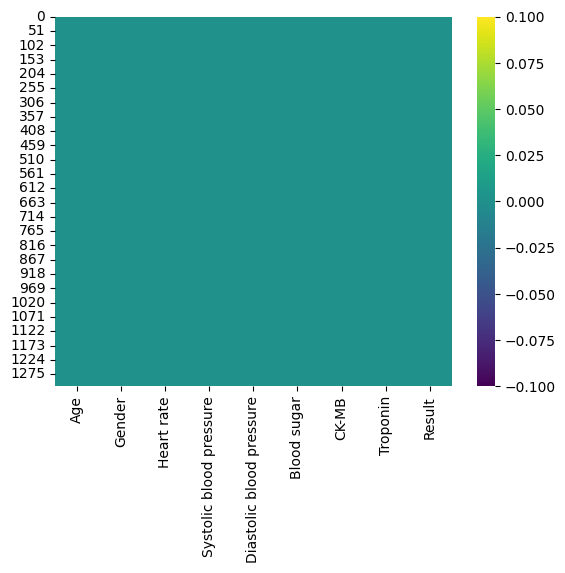

In [9]:
sns.heatmap(df.isnull(), cmap = 'viridis')

# Binarizing the Labels of Result Attribute

In [10]:
le = LabelBinarizer()

In [11]:
df['Result'] = le.fit_transform(df['Result'])
df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,0
1,21,1,94,98,46,296.0,6.75,1.060,1
2,55,1,64,160,77,270.0,1.99,0.003,0
3,64,1,70,120,55,270.0,13.87,0.122,1
4,55,1,64,112,65,300.0,1.08,0.003,0
...,...,...,...,...,...,...,...,...,...
1314,44,1,94,122,67,204.0,1.63,0.006,0
1315,66,1,84,125,55,149.0,1.33,0.172,1
1316,45,1,85,168,104,96.0,1.24,4.250,1
1317,54,1,58,117,68,443.0,5.80,0.359,1


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1319.0,56.191812,13.647315,14.000,47.000,58.000,65.0000,103.0
Gender,1319.0,0.659591,0.474027,0.000,0.000,1.000,1.0000,1.0
Heart rate,1319.0,78.336619,51.630270,20.000,64.000,74.000,85.0000,1111.0
Systolic blood pressure,1319.0,127.170584,26.122720,42.000,110.000,124.000,143.0000,223.0
Diastolic blood pressure,1319.0,72.269143,14.033924,38.000,62.000,72.000,81.0000,154.0
Blood sugar,1319.0,146.634344,74.923045,35.000,98.000,116.000,169.5000,541.0
CK-MB,1319.0,15.274306,46.327083,0.321,1.655,2.850,5.8050,300.0
Troponin,1319.0,0.360942,1.154568,0.001,0.006,0.014,0.0855,10.3
Result,1319.0,0.614102,0.486991,0.000,0.000,1.000,1.0000,1.0


In [13]:
ms = MinMaxScaler()
df = ms.fit_transform(df)
df = pd.DataFrame(df, columns = ['Age', 'Gender', 'Heart rate', 'Systolic blood pressure', 
                                 'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin', 'Result'])
df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.561798,1.0,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0.0
1,0.078652,1.0,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1.0
2,0.460674,1.0,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0.0
3,0.561798,1.0,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1.0
4,0.460674,1.0,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0.0
...,...,...,...,...,...,...,...,...,...
1314,0.337079,1.0,0.067828,0.441989,0.250000,0.333992,0.004368,0.000485,0.0
1315,0.584270,1.0,0.058662,0.458564,0.146552,0.225296,0.003367,0.016604,1.0
1316,0.348315,1.0,0.059578,0.696133,0.568966,0.120553,0.003067,0.412564,1.0
1317,0.449438,1.0,0.034830,0.414365,0.258621,0.806324,0.018283,0.034761,1.0


In [14]:
df['Result'] = df['Result'].apply(lambda x: int(x))
df['Gender'] = df ['Gender'].apply(lambda x : int(x))
df

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,0.561798,1,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068,0
1,0.078652,1,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826,1
2,0.460674,1,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194,0
3,0.561798,1,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749,1
4,0.460674,1,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194,0
...,...,...,...,...,...,...,...,...,...
1314,0.337079,1,0.067828,0.441989,0.250000,0.333992,0.004368,0.000485,0
1315,0.584270,1,0.058662,0.458564,0.146552,0.225296,0.003367,0.016604,1
1316,0.348315,1,0.059578,0.696133,0.568966,0.120553,0.003067,0.412564,1
1317,0.449438,1,0.034830,0.414365,0.258621,0.806324,0.018283,0.034761,1


In [15]:
df['Result'].value_counts()

Result
1    810
0    509
Name: count, dtype: int64

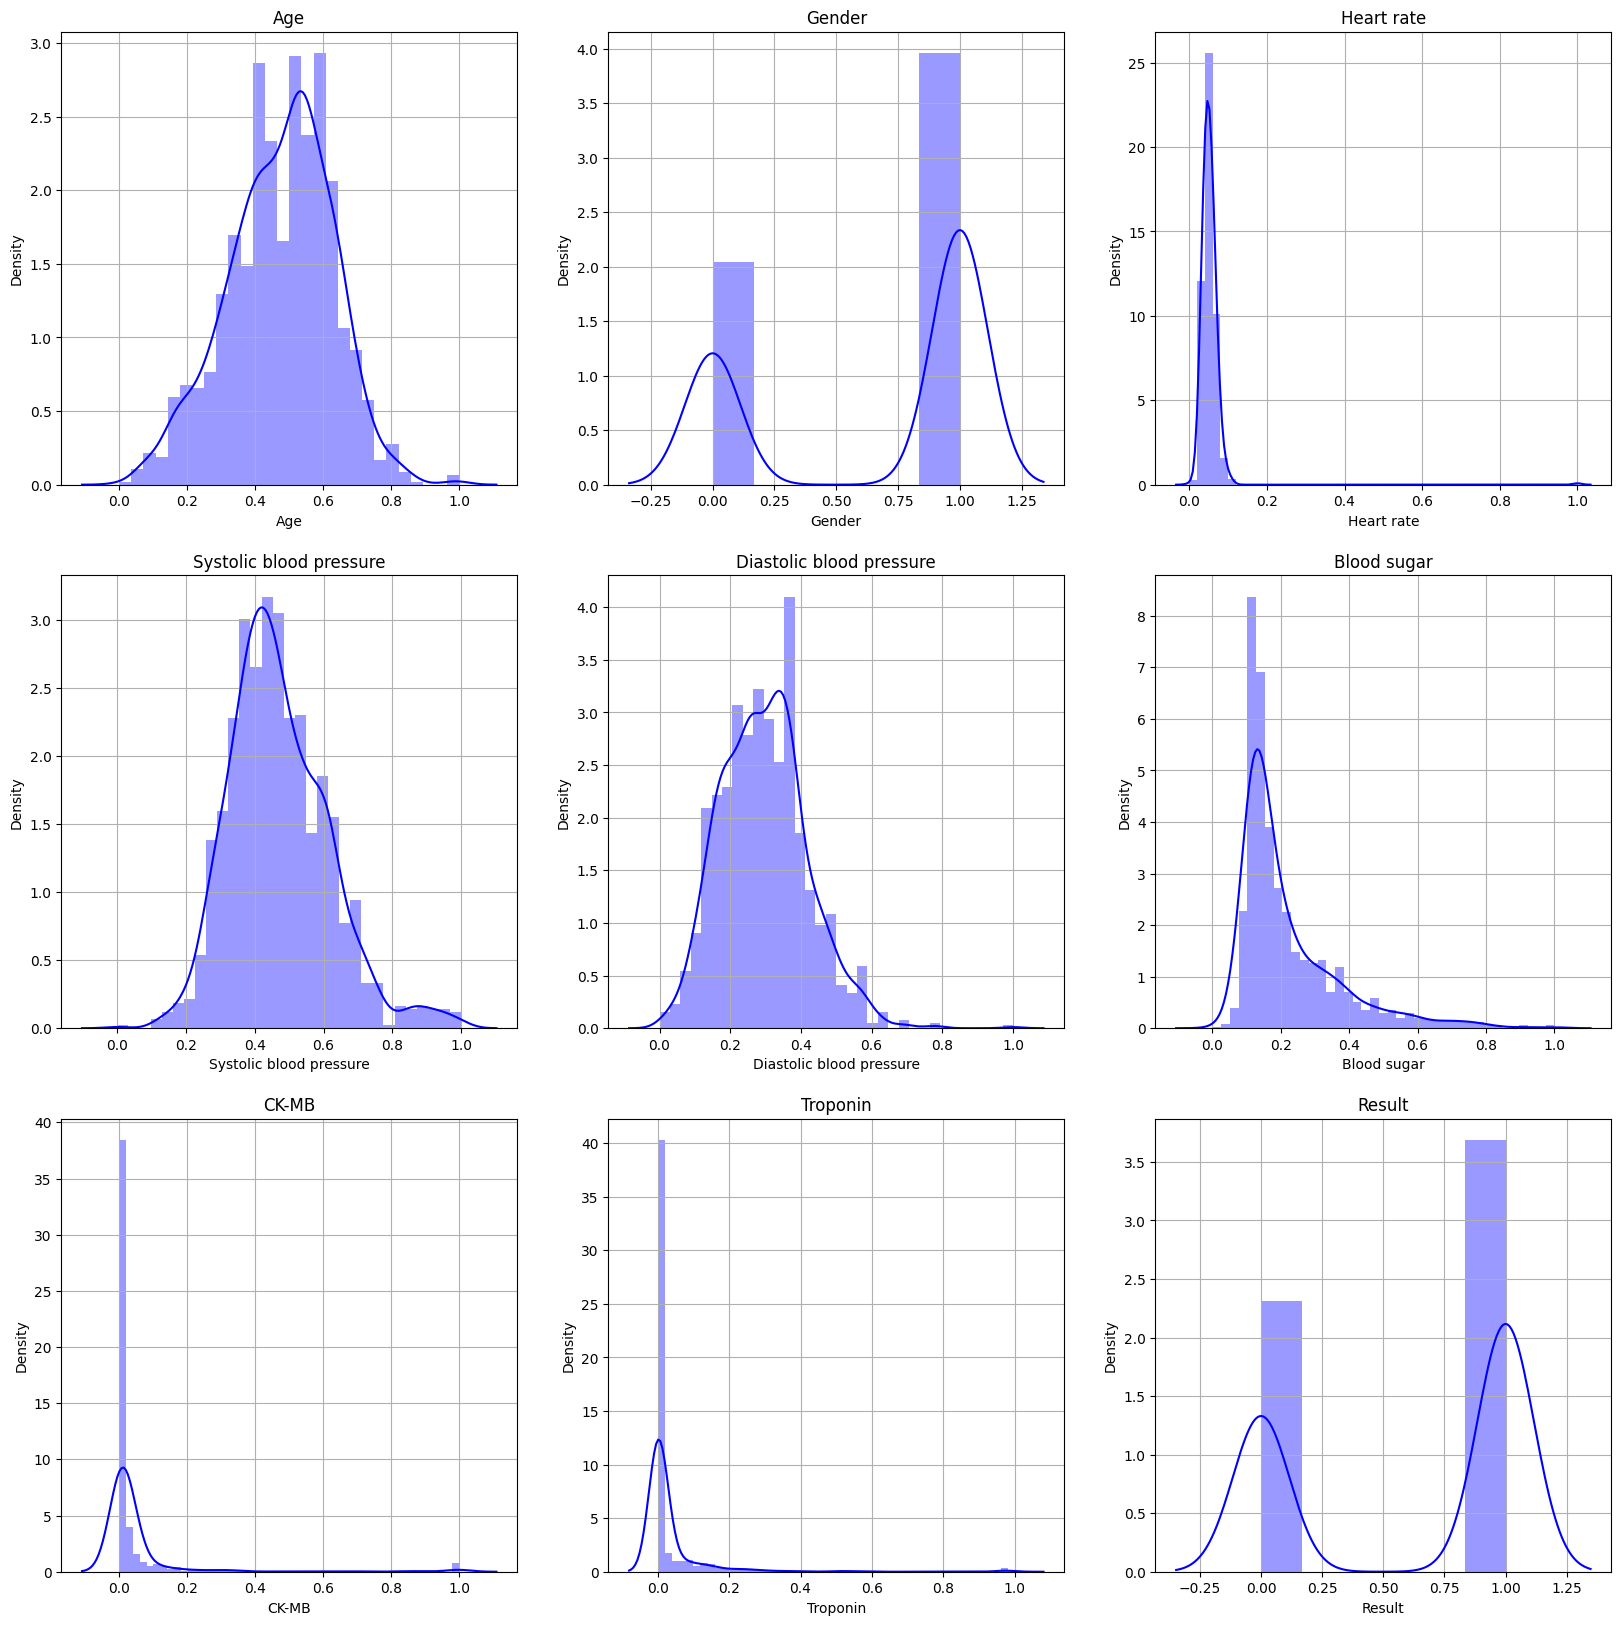

In [16]:
plt.figure(figsize = (20, 20))

for i in range(len(df.columns)):
    plt.subplot(3, 3, i+1)
    plt.title(df.columns[i])
    sns.distplot(df.iloc[:, i], color = 'blue')
    plt.grid()

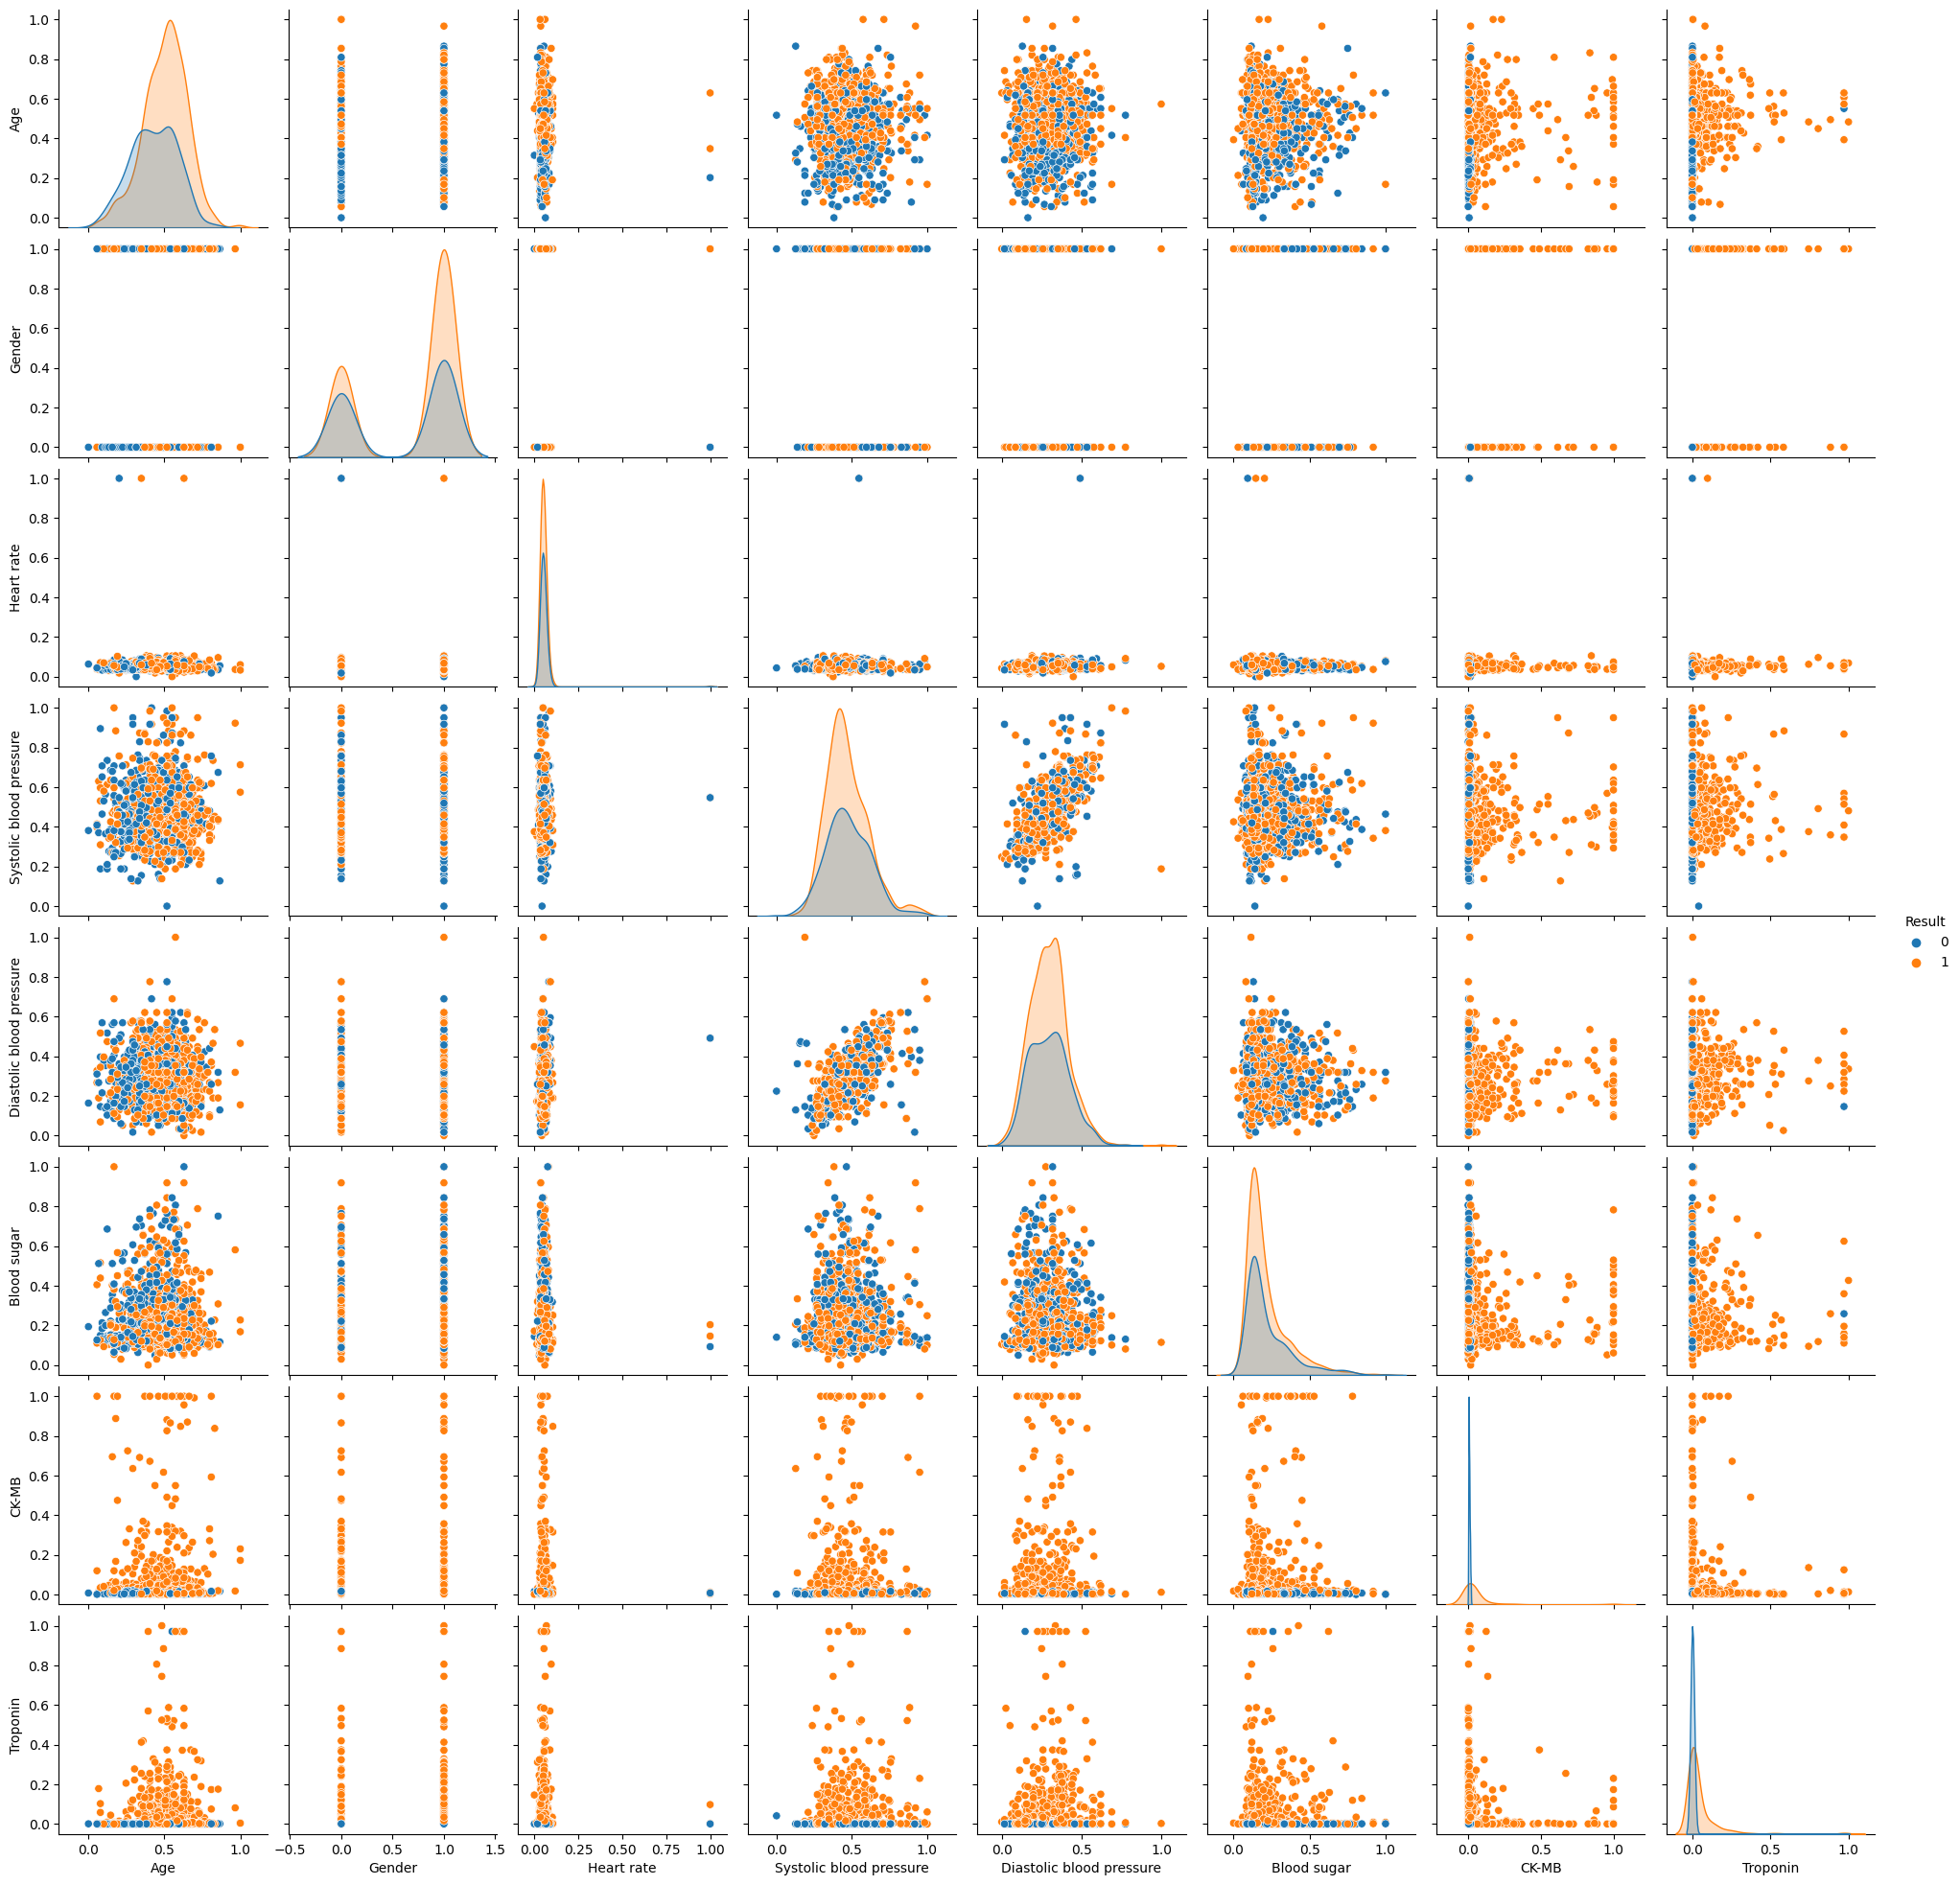

In [17]:
sns.pairplot(df, hue = 'Result')

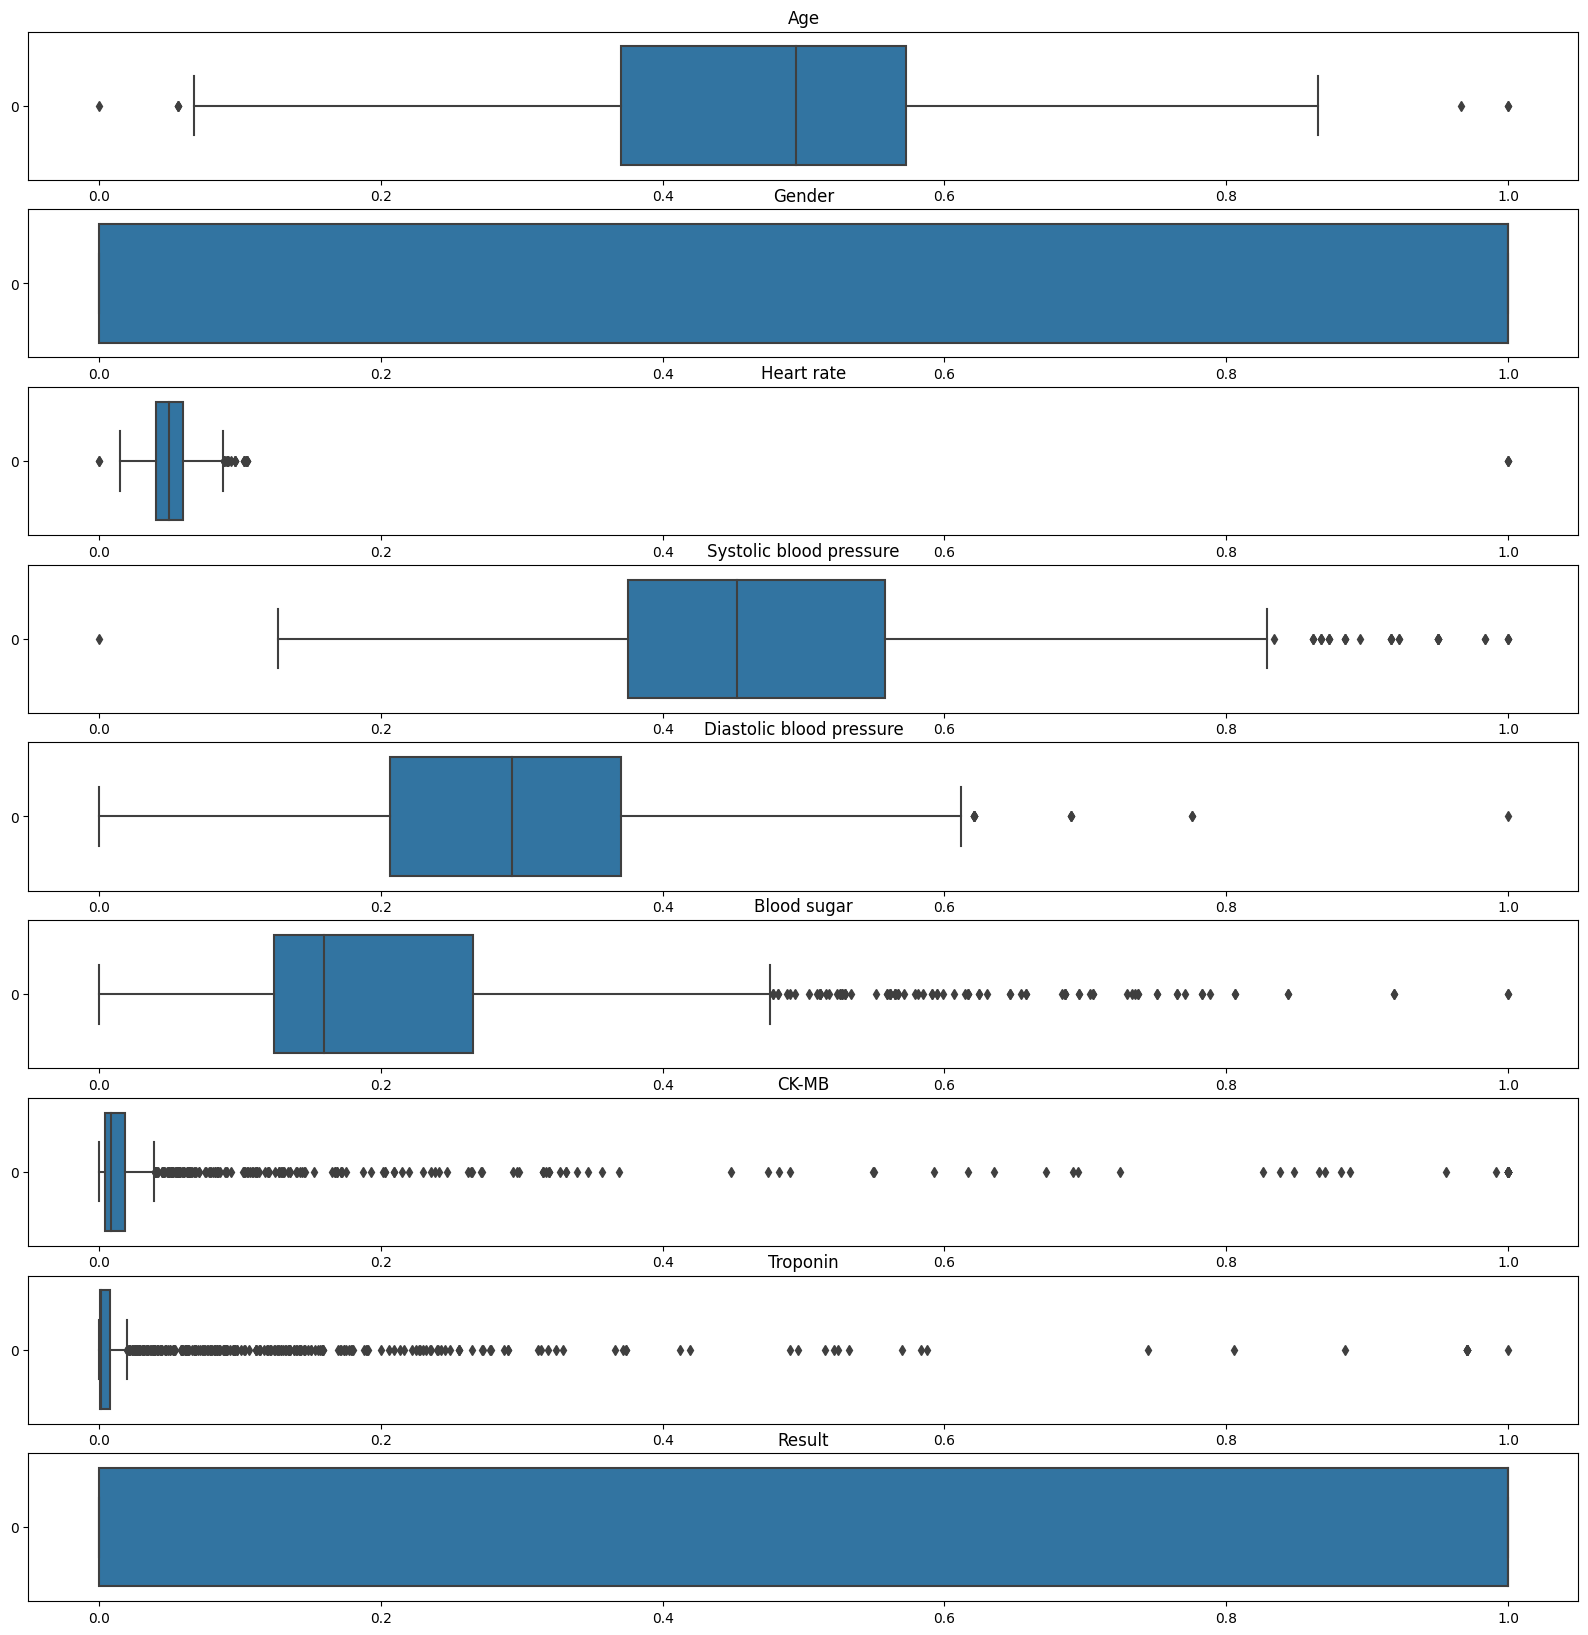

In [18]:
plt.figure(figsize = (20,25))

for i in range(len(df.columns)):
    plt.subplot(11, 1, i+1)
    plt.title(df.columns[i])
    sns.boxplot(df.iloc[:, i], orient = 'h')

In [19]:
z_score = np.abs(zscore(df))

threshold = 3
outlier = df[z_score > threshold]
print(f'Outlier numbers :\n{outlier.notnull().sum()}')

df = df[(z_score < threshold).all(axis = 1)]

Outlier numbers :
Age                          4
Gender                       0
Heart rate                   3
Systolic blood pressure     18
Diastolic blood pressure     6
Blood sugar                 31
CK-MB                       37
Troponin                    26
Result                       0
dtype: int64


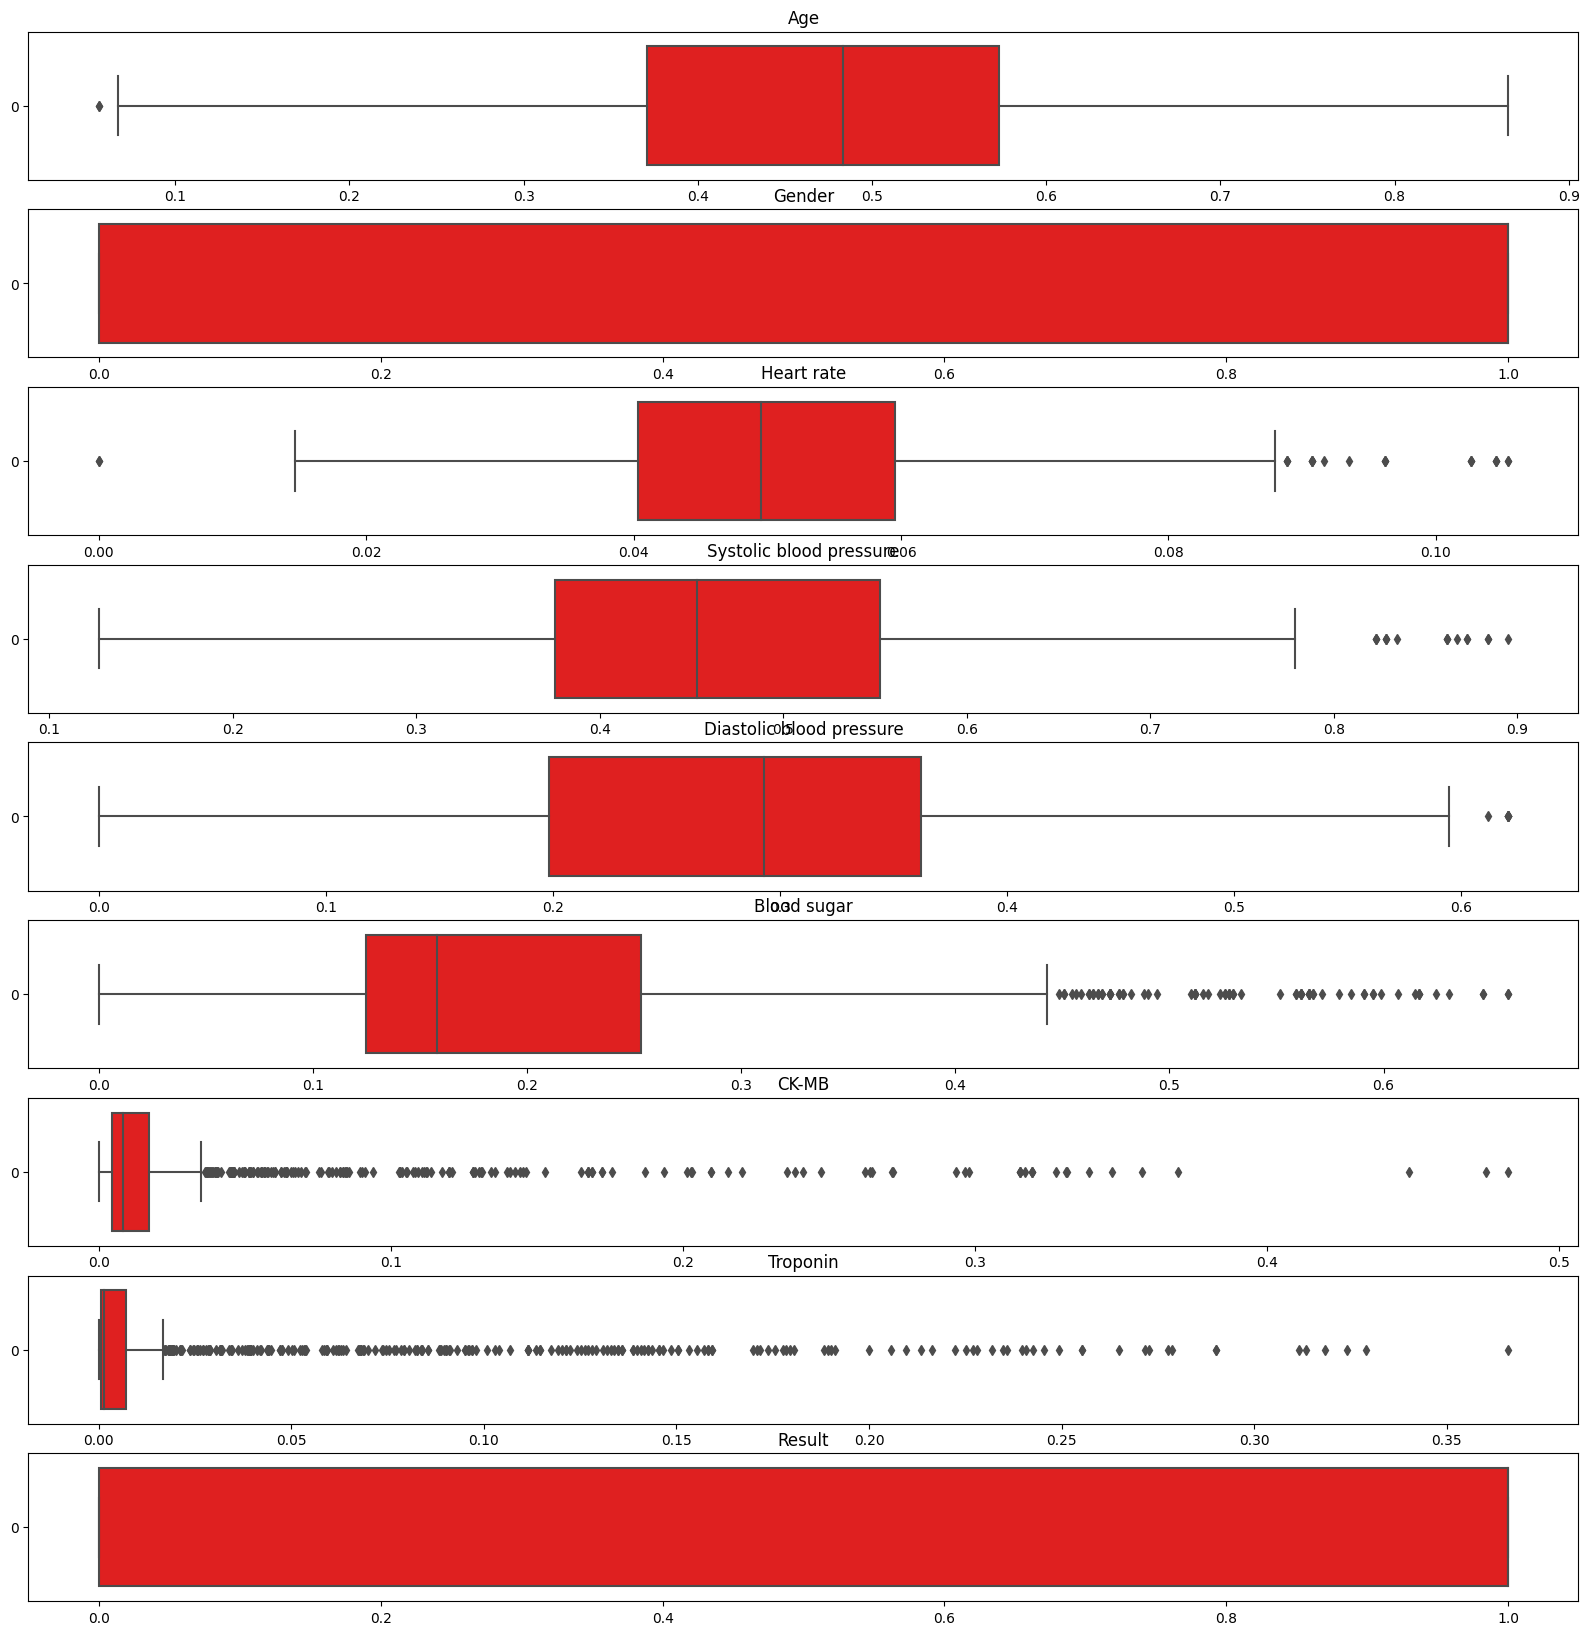

In [20]:
plt.figure(figsize = (20,25))

for i in range(len(df.columns)):
    plt.subplot(11, 1, i+1)
    plt.title(df.columns[i])
    sns.boxplot(df.iloc[:, i], orient = 'h', color = 'red')

In [21]:
df.shape

(1205, 9)

<Axes: >

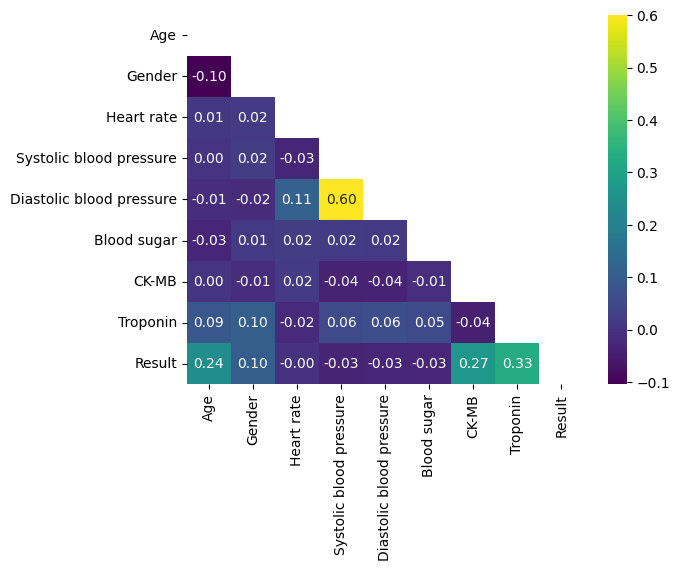

In [22]:
mask = np.triu(df.corr())

sns.heatmap(df.corr(), annot = True, mask = mask, fmt ='.2f', cmap = 'viridis')

# Train and Test Splitting the Data

## Dataset imbalance

In [23]:
imbalance = ((df['Result'] == 1).sum() - (df['Result'] == 0).sum())/ (df['Result'] == 1).sum()
print(f'Imbalance = {imbalance*100}')

Imbalance = 33.10249307479224


In [24]:
x = df.drop('Result', axis = 1)
x

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
0,0.561798,1,0.042163,0.651934,0.387931,0.247036,0.004935,0.001068
1,0.078652,1,0.067828,0.309392,0.068966,0.515810,0.021453,0.102826
2,0.460674,1,0.040330,0.651934,0.336207,0.464427,0.005569,0.000194
3,0.561798,1,0.045830,0.430939,0.146552,0.464427,0.045212,0.011749
4,0.460674,1,0.040330,0.386740,0.232759,0.523715,0.002533,0.000194
...,...,...,...,...,...,...,...,...
1312,0.382022,1,0.058662,0.419890,0.258621,0.120553,0.016715,0.000485
1313,0.808989,0,0.018332,0.756906,0.258621,0.221344,0.016347,0.000971
1314,0.337079,1,0.067828,0.441989,0.250000,0.333992,0.004368,0.000485
1315,0.584270,1,0.058662,0.458564,0.146552,0.225296,0.003367,0.016604


In [25]:
y = df['Result'].values
y

array([0, 1, 0, ..., 0, 1, 1])

## Resampling using SMOTE

In [26]:
sm = SMOTE()
x_resampled, y_resampled = sm.fit_resample(X = df.iloc[:, :8], y = df['Result'])

In [27]:
y_resampled.value_counts()

Result
0    722
1    722
Name: count, dtype: int64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size = 0.25, random_state = 1)

# Defining Performance Evaluation function

In [29]:
def perform(y_pred):
    print(f'Accuracy Score = {accuracy_score(y_test, y_pred)}')
    print(f'Precision Score = {precision_score(y_test, y_pred)}')
    print(f'Recall Score = {recall_score(y_test, y_pred)}')
    print(f'F1 Score = {f1_score(y_test, y_pred)}')
    print(f'ROC-AUC Score = {roc_auc_score(y_test, y_pred)}')
    
    cm = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix = \n{cm}\n')
    
    print('--'*35)
    print(classification_report(y_test, y_pred))
    print('--'*35 + '\n')
    
    cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['False', 'True'])
    cmd.plot()

# 1. Gaussian Naive Bayes

In [30]:
model_gnb = GaussianNB()
model_gnb.fit(x_train, y_train)

GaussianNB()

In [31]:
y_pred_gnb = model_gnb.predict(x_test)

Accuracy Score = 0.9362880886426593
Precision Score = 1.0
Recall Score = 0.8814432989690721
F1 Score = 0.936986301369863
ROC-AUC Score = 0.9407216494845361

Confusion Matrix = 
[[167   0]
 [ 23 171]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       167
           1       1.00      0.88      0.94       194

    accuracy                           0.94       361
   macro avg       0.94      0.94      0.94       361
weighted avg       0.94      0.94      0.94       361

----------------------------------------------------------------------



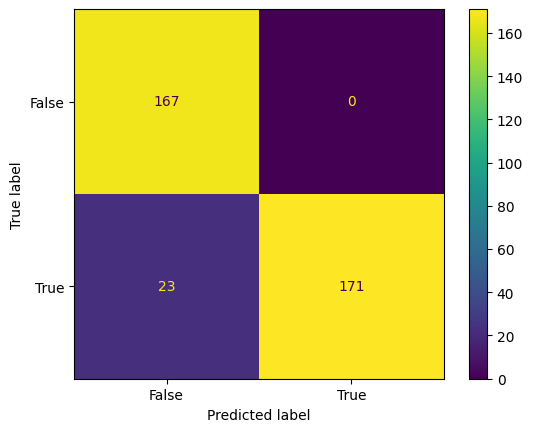

In [32]:
perform(y_pred_gnb)

# 2. Logistic Regression 

In [33]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

In [34]:
y_pred_lr = model_lr.predict(x_test)

Accuracy Score = 0.7063711911357341
Precision Score = 0.7682926829268293
Recall Score = 0.6494845360824743
F1 Score = 0.7039106145251396
ROC-AUC Score = 0.7109698129514167

Confusion Matrix = 
[[129  38]
 [ 68 126]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       167
           1       0.77      0.65      0.70       194

    accuracy                           0.71       361
   macro avg       0.71      0.71      0.71       361
weighted avg       0.72      0.71      0.71       361

----------------------------------------------------------------------



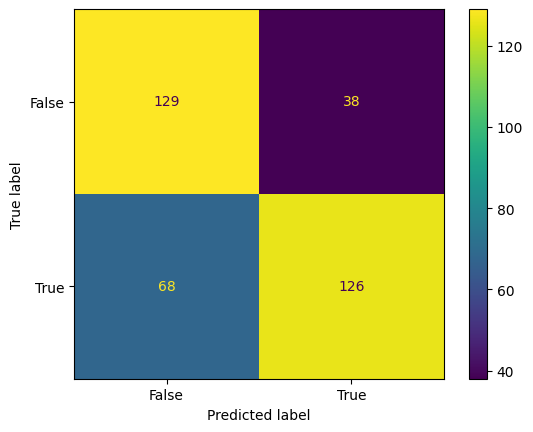

In [35]:
perform(y_pred_lr)

# 3. XGBoost Classifier 

In [36]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
y_pred_xgb = model_xgb.predict(x_test)

Accuracy Score = 0.9916897506925207
Precision Score = 1.0
Recall Score = 0.9845360824742269
F1 Score = 0.9922077922077922
ROC-AUC Score = 0.9922680412371134

Confusion Matrix = 
[[167   0]
 [  3 191]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       167
           1       1.00      0.98      0.99       194

    accuracy                           0.99       361
   macro avg       0.99      0.99      0.99       361
weighted avg       0.99      0.99      0.99       361

----------------------------------------------------------------------



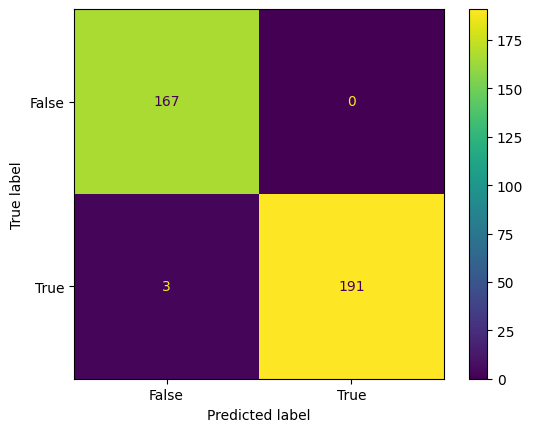

In [38]:
perform(y_pred_xgb)

# 4. Random Forest Classifier

In [39]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [40]:
y_pred_rf = model_rf.predict(x_test)

Accuracy Score = 0.9916897506925207
Precision Score = 1.0
Recall Score = 0.9845360824742269
F1 Score = 0.9922077922077922
ROC-AUC Score = 0.9922680412371134

Confusion Matrix = 
[[167   0]
 [  3 191]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       167
           1       1.00      0.98      0.99       194

    accuracy                           0.99       361
   macro avg       0.99      0.99      0.99       361
weighted avg       0.99      0.99      0.99       361

----------------------------------------------------------------------



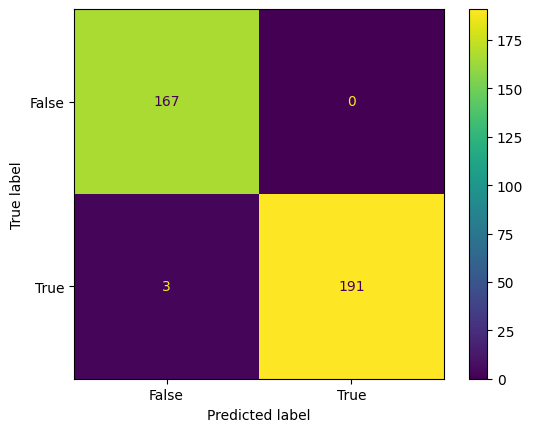

In [41]:
perform(y_pred_rf)

# 5. LightGBM Classifier

In [42]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(x_train, y_train)

LGBMClassifier()

In [43]:
y_pred_lgbm = model_lgbm.predict(x_test)

Accuracy Score = 0.9889196675900277
Precision Score = 1.0
Recall Score = 0.979381443298969
F1 Score = 0.9895833333333333
ROC-AUC Score = 0.9896907216494846

Confusion Matrix = 
[[167   0]
 [  4 190]]

----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       167
           1       1.00      0.98      0.99       194

    accuracy                           0.99       361
   macro avg       0.99      0.99      0.99       361
weighted avg       0.99      0.99      0.99       361

----------------------------------------------------------------------



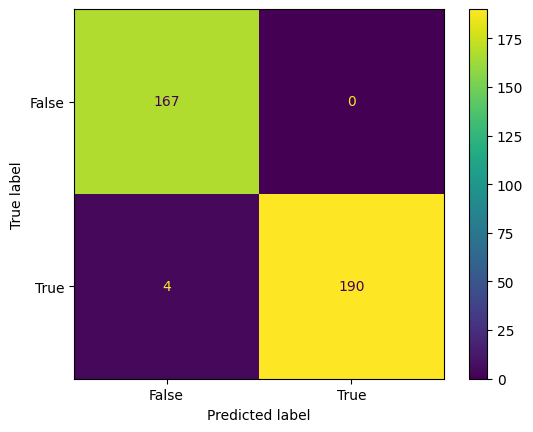

In [44]:
perform(y_pred_lgbm)

# Performance of Other Models using LazyPredict

In [45]:
from lazypredict.Supervised import LazyClassifier

In [46]:
laz = LazyClassifier(verbose = 0, ignore_warnings = True)
models, predictions = laz.fit(x_train, x_test, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 13.09it/s]


In [47]:
mod = pd.DataFrame(models)
mod

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.99,0.99,0.99,0.99,0.02
XGBClassifier,0.99,0.99,0.99,0.99,0.06
AdaBoostClassifier,0.99,0.99,0.99,0.99,0.17
BaggingClassifier,0.99,0.99,0.99,0.99,0.06
RandomForestClassifier,0.99,0.99,0.99,0.99,0.27
LGBMClassifier,0.99,0.99,0.99,0.99,0.40
ExtraTreesClassifier,0.94,0.95,0.95,0.94,0.24
QuadraticDiscriminantAnalysis,0.94,0.94,0.94,0.94,0.02
GaussianNB,0.94,0.94,0.94,0.94,0.02


# Precision-Recall Curve

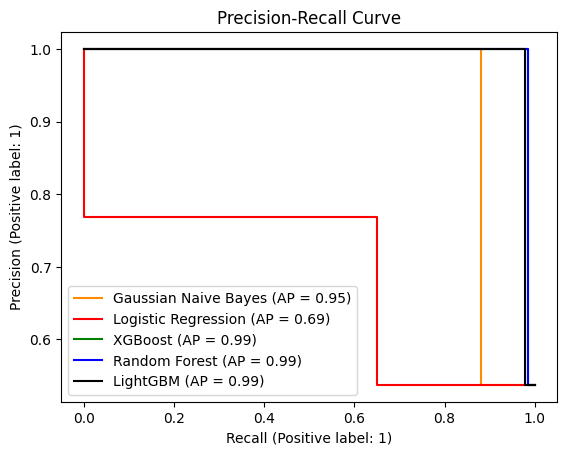

In [48]:
fig, ax = plt.subplots()

plt.title('Precision-Recall Curve')
PrecisionRecallDisplay.from_predictions(y_test, y_pred_gnb, ax=ax, name=f"Gaussian Naive Bayes", color="darkorange")
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lr, ax=ax, name=f"Logistic Regression", color="red")
PrecisionRecallDisplay.from_predictions(y_test, y_pred_xgb, ax=ax, name=f"XGBoost", color="green")
PrecisionRecallDisplay.from_predictions(y_test, y_pred_rf, ax=ax, name=f"Random Forest", color="blue")
PrecisionRecallDisplay.from_predictions(y_test, y_pred_lgbm, ax=ax, name=f"LightGBM", color="black")

# ROC-AUC Curve

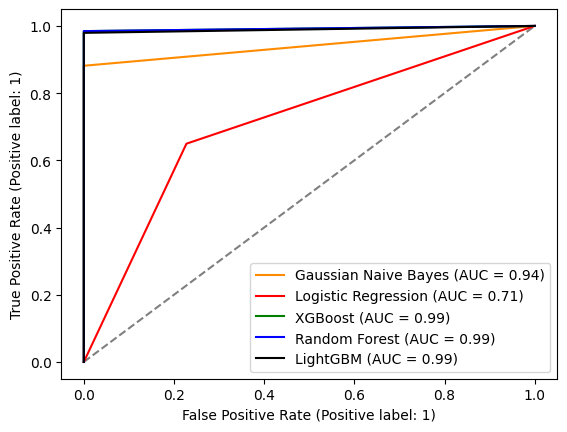

In [49]:
fig, ax = plt.subplots()

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray')
RocCurveDisplay.from_predictions(y_test, y_pred_gnb, ax=ax, name=f"Gaussian Naive Bayes", color="darkorange")
RocCurveDisplay.from_predictions(y_test, y_pred_lr, ax=ax, name=f"Logistic Regression", color="red")
RocCurveDisplay.from_predictions(y_test, y_pred_xgb, ax=ax, name=f"XGBoost", color="green")
RocCurveDisplay.from_predictions(y_test, y_pred_rf, ax=ax, name=f"Random Forest", color="blue")
RocCurveDisplay.from_predictions(y_test, y_pred_lgbm, ax=ax, name=f"LightGBM", color="black")